In [1]:
from pyGROMACS import GROMACS_setup

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

********* JAX NOT FOUND *********
 PyMBAR can run faster with JAX  
 But will work fine without it   
Either install with pip or conda:
      pip install pybar[jax]     
               OR                
      conda install pymbar       
*********************************


## Solvation free energy

This notebook setup and analyse simulations to compute the solvation free energy of a provided solute in the mixture

1) [Optional] Add Guest molecule and equilibrate system
2) [Optional] Optimize the intermediates for decoupling
3) Setup decoupling simulations for each solute for each lambda
4) Analyse the free solvation energy

In [2]:
gromacs_setup = GROMACS_setup( system_setup = "input/system.yaml", 
                               simulation_default = "input/defaults.yaml",
                               simulation_ensemble = "input/ensemble.yaml",
                               submission_command = "qsub"
                             )

### 1) [Optional] Add Guest molecule and equilibrate system

In [7]:
# Define the simulation folder
simulation_folder = "solvation_free_energy"

# Define the ensembles that should be simulated (definition what each ensemble means is provided in yaml file)
ensembles = [ "em", "nvt", "npt_equilibration", "npt_production" ]

# Define the simulation time per ensemble in nano seconds (for em provide number of iterations)
simulation_times = [ 10000, 1.0, 1.0, 1.0 ]

# Define initial systems, in case the simulation should be continued from a prior simulation.
# Therefore, provide one initial structure for each temperature & pressure state.
# If none are specified, gmx-insert will create them.
initial_systems = []

# Provide kwargs that should be passed into the mdp template directly
mdp_kwargs = {}

# Define number of copies
copies = 2

# Define if the inital system should build locally or with the cluster
on_cluster = False

# Define the solutes (names should match the residue)
solutes = [ "CO2" ]


for solute in solutes:

    # Increase the molecule number of the solute in the system by one
    for mol_dict in gromacs_setup.system_setup["molecules"]:
        if mol_dict["name"] == solute:
            mol_dict["number"] +=1
            break


    gromacs_setup.prepare_simulation( folder_name = f"{simulation_folder}/{solute}/equilibration", ensembles = ensembles, 
                                      simulation_times = simulation_times, initial_systems = initial_systems, 
                                      mdp_kwargs = mdp_kwargs, copies = copies, on_cluster = on_cluster 
                                    )

    # Decrease it again, that next solute has correct system
    mol_dict["number"] -=1

State: T = 313.1 K, P = 1.0 bar

Building system based on provided molecule numbers and coordinate files!


Build system locally! Wait until it is finished.

Build successful



In [8]:
# Submit the simulations
gromacs_setup.submit_simulation()


Submitting simulations at Temperature = 313 K, Pressure = 1 bar

Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/equilibration/temp_313.1_pres_1.0/copy_0/job_313.sh
11444842


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/equilibration/temp_313.1_pres_1.0/copy_1/job_313.sh
11444843


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/equilibration/temp_313.1_pres_1.0/copy_2/job_313.sh
11444844




### 2) [Optional] Optimize the intermediates for decoupling

### 3) Setup decoupling simulations for each solute for each lambda

In [10]:
# Define the simulation folder
simulation_folder = "solvation_free_energy"

# Define ensembles, the meaning of each ensemble is defined in the simulation_ensemble yaml
ensembles = [ "em", "nvt", "npt_equilibration", "npt_production" ]

# Define simulation time per ensemble in nanoseconds (for "em" provide number of optimization steps)
simulation_times = [ 10000, 2.0, 2.0, 10.0 ]

# Define the number of copies for each system
copies = 0

# Define the starting number for the first ensemble ( 0{off_set}_ensemble )
off_set = 0

# Solutes
solutes = [ "CO2" ]

# Define lambdas that should be used (for each solute individual)
combined_lambdas = [ [0.00, 0.25, 0.50, 0.75, 1.00, 1.05, 1.10, 1.20, 1.30, 1.40, 1.50, 1.60, 1.65, 1.70, 1.75, 1.80, 1.85, 1.90, 1.95, 2.00 ] ]

# Ensure that all jobs for all solutes are submitted at once
job_files = [ [] for _ in gromacs_setup.system_setup["temperature"] ]

for i,solute in enumerate( solutes ):

    # Define initial systems for each temperature & pressure state, based on the equilibration done before
    initial_systems = [ f"/home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/{solute}/equilibration/temp_313.1_pres_1.0/copy_1/03_npt_production/npt_production.gro" ]

    # Increase the molecule number of the solute in the system by one (important for toplogy file and if initial system is not provided)
    for mol_dict in gromacs_setup.system_setup["molecules"]:
        if mol_dict["name"] == solute:
            mol_dict["number"] +=1
            break

    gromacs_setup.prepare_free_energy_simulation( folder_name = simulation_folder, simulation_free_energy = "input/free_energy.yaml", solute = solute, 
                                                  combined_lambdas = combined_lambdas[i], initial_systems = initial_systems, ensembles = ensembles,
                                                  copies = copies, simulation_times = simulation_times, off_set = off_set  )

    # Decrease it again, that next solute has correct system
    mol_dict["number"] -=1
    
    for j, files in enumerate( gromacs_setup.job_files ):
      job_files[j].extend( files )

gromacs_setup.job_files = job_files

State: T = 298.1 K, P = 1.0 bar

System already build and initial configuration is provided at:
   /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/equilibration/temp_298.1_pres_1.0/copy_1/03_npt_production/npt_production.gro

Checkpoint file (.cpt) is provided in the same folder.



In [11]:
# Submit the simulations
gromacs_setup.submit_simulation()


Submitting simulations at Temperature = 298 K, Pressure = 1 bar

Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298_pres_1/copy_0/lambda_0/job_298_lambda_0.sh
11438887


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298_pres_1/copy_0/lambda_1/job_298_lambda_1.sh
11438888


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298_pres_1/copy_0/lambda_2/job_298_lambda_2.sh
11438889


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298_pres_1/copy_0/lambda_3/job_298_lambda_3.sh
11438890


Submitting job: /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298_pres_1/copy_0/lambda_4/job_298_lambda_4.sh


## Data analysis

This generic tool allows to extract properties using GROMACS commands for an specified simulation folder and ensemble. This will average the properties over each copy and safe the produced data in each temperature & pressure folder as json file


### Extract and analysis of solvation free energies


Extract solvation free energy results for solute: CO2

Temperature: 298.15 K, Pressure: 1.0 bar
   /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298.1_pres_1.0/copy_0/lambda_0/03_npt_production/npt_production.xvg
   /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298.1_pres_1.0/copy_0/lambda_1/03_npt_production/npt_production.xvg
   /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298.1_pres_1.0/copy_0/lambda_2/03_npt_production/npt_production.xvg
   /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298.1_pres_1.0/copy_0/lambda_3/03_npt_production/npt_production.xvg
   /home/st/st_st/st_ac137577/workspace/software/pyGROMACS/example/solvation/co2_water/solvation_free_energy/CO2/temp_298.1_pres_1.0/copy_0/lambda_4/03_npt_pro

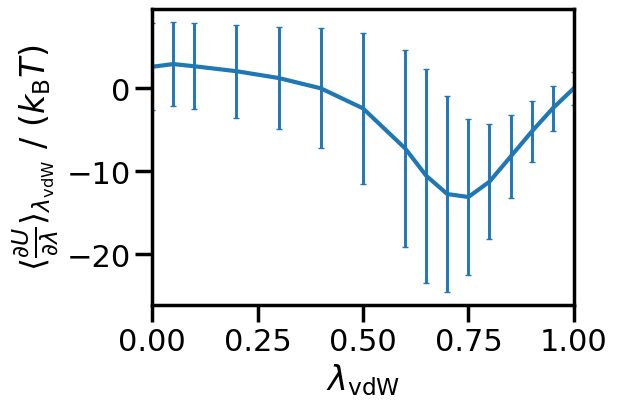

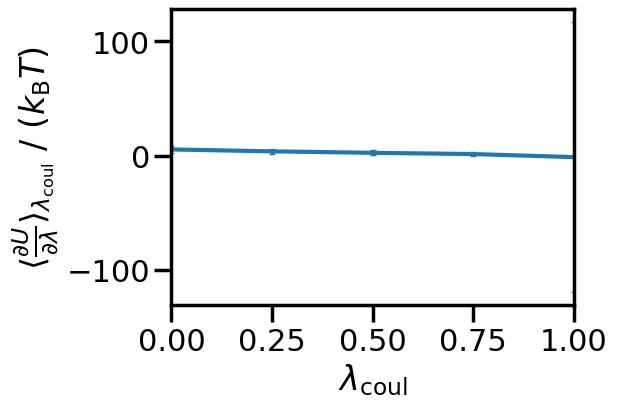


Following combined lambda states were analysed with the 'TI' method:
   0.0, 0.25, 0.5, 0.75, 1.0, 1.05, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.65, 1.7, 1.75, 1.8, 1.85, 1.9, 1.95, 2.0

Averaged values over all copies:

                 property      mean       std    unit
0  solvation_free_energy  1.582694  0.037642  kJ/mol 



In [3]:
# Extract solvation free energy results 

# Define analysis folder
analysis_folder = "solvation_free_energy"

# Define analysis ensemble
ensemble = "03_npt_production"

# Solutes
solutes  = [ "CO2" ] 

# Free energy method (MBAR, BAR, TI, TI_spline)
method = "TI"

# Decorrelate free energy data (using alchemlyb tools)
decorrelate = False

# Define if coupling (True) or decoupling (False) is performed
coupling = False

for solute in solutes:
    gromacs_setup.analysis_free_energy( analysis_folder = analysis_folder, ensemble = ensemble, solute = solute,
                                        method = method, fraction = 0.25, decorrelate = decorrelate, 
                                        visualize = True, coupling = coupling )